<a href="https://colab.research.google.com/github/keethu12345/Election_Data_Analysis/blob/main/Project_1_TDS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing all the necessary libraries:

In [ ]:
import requests
import json
import pandas as pd
import numpy as np
from urllib.parse import urljoin
from tqdm import tqdm
from time import sleep
from geopy.geocoders import Nominatim
from geopy.distance import geodesic
import seaborn as sns
import matplotlib.pyplot as plt

### Performing some Data scraping:

In [ ]:
def get_data_and_next_page(response_text:str):
    start_idx = response_text.find('const data =') + len('const data =')
    end_idx = response_text.rfind(';', start_idx, response_text.find('const next ='))
    data_json = response_text[start_idx:end_idx].strip()
    data = json.loads(data_json)

    start_idx = response_text.find('const next =') + len('const next =')
    end_idx = response_text.find(';', start_idx)
    next_page = response_text[start_idx:end_idx].strip().strip('"')

    return data, next_page

def navigate_next(base_url, next_page):
    if next_page != "null":
        return urljoin(base_url, next_page)
    else:
        return None

def scrape_data(base_url, state_data):
    election_data = {"ID": [], "ST_NAME": [], "YEAR": [], "AC": [],
                 "CANDIDATE": [], "SEX": [], "AGE": [], "CATEGORY": [],
                 "PARTY": [], "VOTES": []}
    for entry in state_data:
        next = entry['link']
        url = urljoin(base_url, next)
        while True:
            response = requests.get(url)
            data, next_page = get_data_and_next_page(response.text)
            for row in tqdm(data, desc=f"Scraping data for year {entry['YEAR']}"):
                for key in election_data.keys():
                    election_data[key].append(str(row.get(key, list(row.values())[0])).strip())
            url = navigate_next(base_url, next_page)
            if not url:
                break
    return election_data

def save(ST_NAME, AC_NAME, election_data):
    df = pd.DataFrame(election_data)
    df.replace('', np.nan, inplace=True)
    df = df[df['VOTES'].notna()]
    df['AC'] = df['AC'].str.replace(r'^\d+\s+', '', regex=True)
    df['AC'] = df['AC'].str.replace(r'[^a-zA-Z\s\.]', '', regex=True)
    df['CANDIDATE'] = df['CANDIDATE'].str.replace(r'^\d+\s+', '', regex=True)
    df['CANDIDATE'] = df['CANDIDATE'].str.replace(r'[^a-zA-Z\s\.]', '', regex=True)
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    df.drop_duplicates(inplace=True)
    df.to_csv(f"{ST_NAME}.csv", index=False)
    condition = (df["AC"] == AC_NAME)
    df = df[condition]
    df.to_csv(f"{ST_NAME}_{AC_NAME}.csv", index=False)

def find_state_data(start_url, ST_NAME):
    url = start_url
    state_data = []
    n_pages = 10
    for i in tqdm(range(n_pages), desc="Crawling all pages"):
        if url:
            response = requests.get(url)
            data, next_page = get_data_and_next_page(response.text)
            state_data.extend([entry for entry in data if entry['ST_NAME'] == ST_NAME])
            url = navigate_next(start_url, next_page)
    return state_data

def main_scraper(ST_NAME, AC_NAME):
    start_url = "https://22f3001919.github.io/tds_project_1/"
    state_data = find_state_data(start_url, ST_NAME)

    if not state_data:
        print(f"No data found for state: {ST_NAME}")
        return

    election_data = scrape_data(start_url, state_data)
    save(ST_NAME, AC_NAME, election_data)
    return election_data


In [ ]:
ST_NAME = "KERALA"
AC_NAME = "THIRUVALLA"
# saves full state csv and also constituency csv
# scraped data undergoes priliminary cleaning as well
data = main_scraper(ST_NAME, AC_NAME)

Scraping data for year 2021: 100%|██████████| 418/418 [00:00<00:00, 92537.69it/s]


## Terminologies
- **Vote Share** - votes of the candidate divided by the total votes in that election year expressed as a percentage
- **Gap between elections** -Candidate might not contest in election in consecutive years but take a break and contest after few terms.Eg candidate 'A' contested in election conducted in 1994 and 2004 but didnot contest in the election between 1994-2004
- **Margin percentage** - difference in voteshare between contestants
- **Lose the deposit** - When the candidate failed to secure at least 1/6th of the total votes cast in that election year
- **Absolute majority** - When the candidate secures a vote share exceeding 50%


## Questions

### Question 1:

For the  given AC_NAME, Identify the candidate who had the greatest change in vote share compared to the previous election, regardless of the gap between elections? [string]
- Do not consider NOTA as candidate (but NOTA votes are to be considered as part of the total votes)
- If no candidate has participated in two elections, then the answer will be NA
- If two candidates have the same vote share change, choose the candidate who came first alphabetically

In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
ac_df = ac_df[ac_df['VOTES'].notna()]
ac_df['TOTAL_VOTES'] = ac_df.groupby('YEAR')['VOTES'].transform('sum')
ac_df = ac_df[ac_df['CANDIDATE'] != "NOTA"]
ac_df['VOTE_SHARE'] = (ac_df['VOTES'] / ac_df['TOTAL_VOTES']) * 100
pivot_table = ac_df.pivot_table(values='VOTE_SHARE', index='CANDIDATE', columns='YEAR', aggfunc='sum')
pivot_table = pivot_table.dropna(thresh=2)
def calc_abs_diffs(series):
    non_nan_values = series.dropna()
    abs_diffs = non_nan_values.diff().abs().dropna()
    return abs_diffs

abs_diffs_df = pivot_table.apply(calc_abs_diffs, axis=1)
print("List of candidates sorted in decreasing order of change in vote share:")
abs_diffs_df.max(axis=1).sort_values(ascending=False)

List of candidates sorted in decreasing order of change in vote share:


CANDIDATE
G. P. THAMPI        15.670675
E. JOHN JACOB       10.740782
P. C. THOMAS         9.345625
NIRANAM RAJAN        0.418813
MATHEW T. THOMAS     0.160586
KRISHNAN KUTTY       0.107099
dtype: float64

### Question 5:
For the given AC_NAME, In which year did the winning candidate have the biggest margin percentage win over the runner up? [string]
- If there are two or more years with the same winning margin, choose the latest one


In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
runner_ups = ac_df.drop(winners.index)
runner_ups = ac_df.loc[runner_ups.groupby('YEAR')['VOTES'].idxmax()]
total_votes =  ac_df.groupby('YEAR')['VOTES'].sum().values
winners["VOTE_SHARE"] = 100 * ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
runner_ups["VOTE_SHARE"] = 100 * ac_df.loc[runner_ups.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
winners["MARGIN"] = winners["VOTE_SHARE"].values - runner_ups["VOTE_SHARE"].values
print("List of years sorted in decreasing order of margin with runner up:")
winners.groupby("YEAR")["MARGIN"].sum().sort_values(ascending=False)

List of years sorted in decreasing order of margin with runner up:


YEAR
1965    28.667564
1960    28.628960
2006    12.542702
2001    12.249644
1977    11.973221
1982     9.453034
2011     8.501919
2021     8.184515
1970     7.854880
1996     7.121964
1957     5.797325
2016     5.715986
1967     3.894697
1991     2.464170
1980     2.056203
1987     1.635967
Name: MARGIN, dtype: float64

### Question 8:

For the given AC_NAME, how many candidates lost their deposit across the entire dataset?[integer]
- If there is only one candidate in an election, the candidate does not lose their deposit.
- Don't consider Nan/NA/blank votes
- NOTA are not candidates

In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
ac_df['DEPOSIT_THRESHOLD'] = 1/6 * ac_df.groupby('YEAR')['VOTES'].transform('sum')
ac_df = ac_df[ac_df['CANDIDATE'] != "NOTA"]
ac_df[ac_df['VOTES'] < ac_df['DEPOSIT_THRESHOLD']].shape[0]

53

### Question 9:

For the  given AC_NAME, In how many elections did the winner get more than 50 percent of the vote? [integer]

In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
total_votes = ac_df.groupby('YEAR')['VOTES'].sum().values
winners['VOTE_SHARE'] = 100 * winners["VOTES"].values / total_votes
winners[winners['VOTE_SHARE'] > 50].shape[0]

7

### Question 10:

 What is the latest year in which the winner won more than 50 percent of the vote? [string]
- If no one got more than 50 percent of the vote, then the answer is NA


In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
total_votes =  ac_df.groupby('YEAR')['VOTES'].sum().values
winners["VOTE_SHARE"] = 100 * ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()]["VOTES"].values / total_votes
winners_above_50 = winners[winners["VOTE_SHARE"] > 50]
winners_above_50["YEAR"].max()

2001

### Question 11:


For the given AC_NAME, Which party won the highest number of election in a given constituency? [string]
- If two or more parties have the same number of highest wins, choose the party that is alphabetically first
- If independent candidates won the highest number of elections then the answer is IND


In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
winners = ac_df.loc[ac_df.groupby('YEAR')['VOTES'].idxmax()].copy()
print("Frequency of party winning the elections:")
winners["PARTY"].value_counts().sort_values(ascending=False)

Frequency of party winning the elections:


PARTY
JD(S)     4
KEC       3
JNP       2
KEC(M)    2
CPI       1
INC       1
KC        1
IND       1
KCM       1
Name: count, dtype: int64

### Question 12:

 For the  given AC_NAME, If the second and the third candidate in an election combined their vote, how many elections would they win? [integer]
- Do not count elections where there are less than 3 candidates, count these as 0

In [ ]:
ac_df = pd.read_csv(f"{ST_NAME}_{AC_NAME}.csv")
year_counts = ac_df["YEAR"].value_counts()
filtered_years = year_counts[year_counts >= 3].index
filtered_df = ac_df[ac_df['YEAR'].isin(filtered_years)].sort_values(by=['YEAR', 'VOTES'], ascending=[True, False])
second_third_candidates = filtered_df.groupby('YEAR').head(3).groupby('YEAR').tail(2)
second_third_combined = second_third_candidates.groupby('YEAR')["VOTES"].sum()
winner_count = filtered_df.groupby('YEAR').head(1).groupby('YEAR')["VOTES"].sum()
result = (winner_count - second_third_combined) < 0
result.sum()

7

### Question 15:

 For a given constituency, how many constituencies within the same state are less than 20 kms. Use Nominatim for this question.

In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
def get_coordinates(state:str, constituency:str):
    try:
        geolocator = Nominatim(user_agent="Mozilla/5.0")
        location = geolocator.geocode(f"{constituency.lower()}, {state.lower()}, India")
        # print(location)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except:
        return None, None

def calculate_distance(given_coords, lat, lon):
    try:
        if lat and lon:
            return geodesic(given_coords, (lat, lon)).kilometers
        else:
            return None
    except:
        return None
print("Getting latitude and longitude for all constituencies..")
constituency_list = {place:() for place in state_df["AC"].unique()}
for key in constituency_list.keys():
    sleep(2)
    constituency_list[key] = get_coordinates(ST_NAME, key)
print("Done")
temp_df = state_df.copy()
temp_df['LAT'], temp_df['LON'] = zip(*state_df.apply(lambda row: constituency_list[row["AC"]], axis=1))
given_coords = temp_df.loc[state_df['AC'] == AC_NAME, ['LAT', 'LON']].values[0]
temp_df['DISTANCE'] = temp_df.apply(lambda row: calculate_distance(given_coords, row['LAT'], row['LON']), axis=1)
nearby_constituencies = temp_df[(temp_df['DISTANCE'] < 20) & (temp_df['AC'] != AC_NAME)]
print("Count of constituencies within 20 kms:")
nearby_constituencies['AC'].unique().shape

### Question 17:

Find the Pearson correlation coefficient between the votes won by female candidates and male candidates. Only include constituencies and election years that had at least 1 female candidate. Each row in the correlation data table should represent an election. Round off the answer to 4 decimal points[float]

In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
df_filtered = state_df.groupby(['YEAR', 'AC']).filter(lambda x: (x['SEX'] == 'F').any())
df_female = df_filtered[df_filtered['SEX'] == 'F'][['YEAR', 'VOTES']].rename(columns={'VOTES': 'FEMALE_VOTES'})
female_votes_by_year = df_female.groupby('YEAR')['FEMALE_VOTES'].sum()
df_male = df_filtered[df_filtered['SEX'] == 'M'][['YEAR', 'VOTES']].rename(columns={'VOTES': 'MALE_VOTES'})
male_votes_by_year = df_male.groupby('YEAR')["MALE_VOTES"].sum()
male_votes_by_year.corr(female_votes_by_year)

0.9628407035835025

### Question 18:

 For a given state, identify the election year which has the most outliers on the basis of candidate votes. Use the interquartile range (IQR) rule to detect outliers. [integer]

In [ ]:
state_df = pd.read_csv(f"{ST_NAME}.csv")
grouped = state_df.groupby('YEAR')
Q1 = grouped['VOTES'].transform(lambda x: x.quantile(0.25))
Q3 = grouped['VOTES'].transform(lambda x: x.quantile(0.75))
IQR = Q3 - Q1
lb = Q1 - 1.5 * IQR
ub = Q3 + 1.5 * IQR
condition = (state_df['VOTES'] < lb) | (state_df['VOTES'] > ub)
print("List of years sorted in descending order of number of outliers:")
state_df[condition]["YEAR"].value_counts()

List of years sorted in descending order of number of outliers:


YEAR
1996    284
1987    282
2016    185
1960     15
1957      9
Name: count, dtype: int64

In [ ]:
!ls -l

total 844
-rw-r--r-- 1 root root 850262 Jul 17 14:16 KERALA.csv
-rw-r--r-- 1 root root   6458 Jul 17 14:16 KERALA_THIRUVALLA.csv
drwxr-xr-x 1 root root   4096 Jul 15 13:27 sample_data


In [ ]:
# Compress files into a zip archive
!zip -r my_files.zip folder_name_or_pattern

# Download the zip archive
from google.colab import files
files.download('KERALA.csv')
files.download('KERALA_THIRUVALLA.csv')

	zip warning: name not matched: folder_name_or_pattern

zip error: Nothing to do! (try: zip -r my_files.zip . -i folder_name_or_pattern)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Essay Assignment

###Question 1:

For the given state, Use Box-Whiskers plot / violin plot to display the outliers in candidate votes for each election year. Use a different colour to clearly highlight the outliers. Do not consider candidates with NaN/null/None/blank votes. 0 votes is a valid vote count. NOTA is a valid candidate.

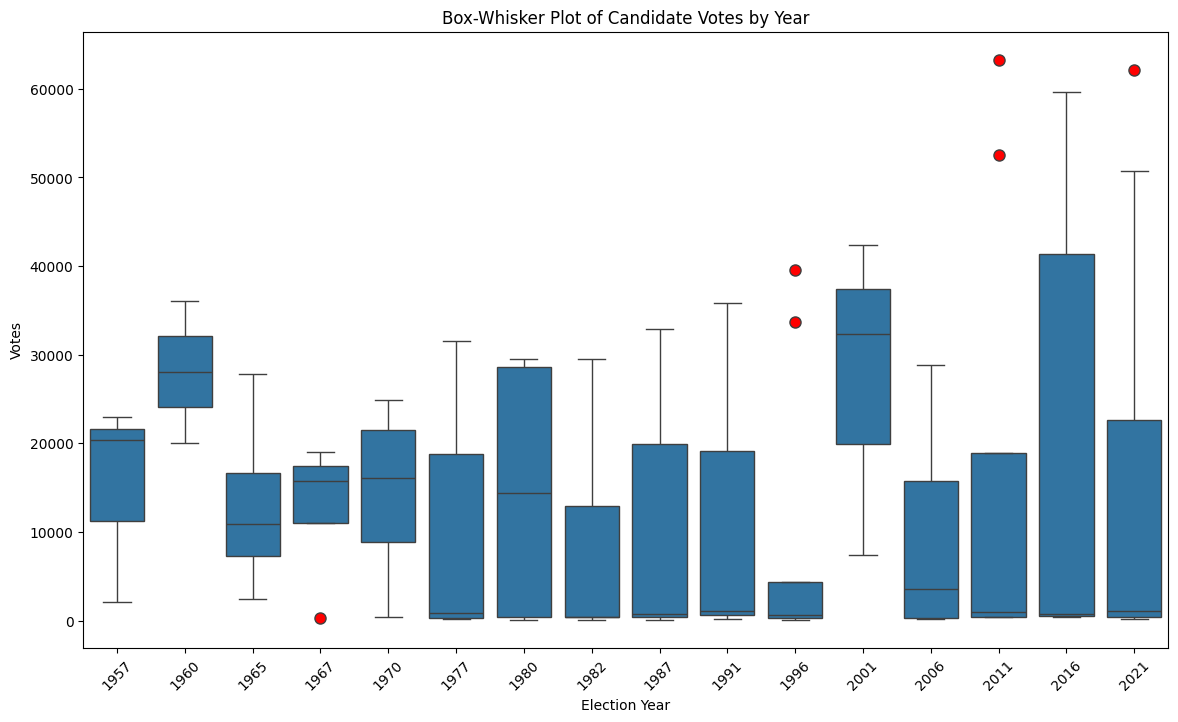

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = './KERALA_THIRUVALLA.csv'
data = pd.read_csv(file_path)

cleaned_data = data.dropna(subset=['VOTES'])


cleaned_data['VOTES'] = pd.to_numeric(cleaned_data['VOTES'], errors='coerce')


cleaned_data = cleaned_data.dropna(subset=['VOTES'])


plt.figure(figsize=(14, 8))
sns.boxplot(x='YEAR', y='VOTES', data=cleaned_data, showfliers=True,
            flierprops={'markerfacecolor':'r', 'markersize':8})
plt.title('Box-Whisker Plot of Candidate Votes by Year')
plt.xlabel('Election Year')
plt.ylabel('Votes')
plt.xticks(rotation=45)
plt.show()


For the given state, Use a scatter plot to show the correlation between the length of a candidate name (string length) and the votes gathered by the candidate.

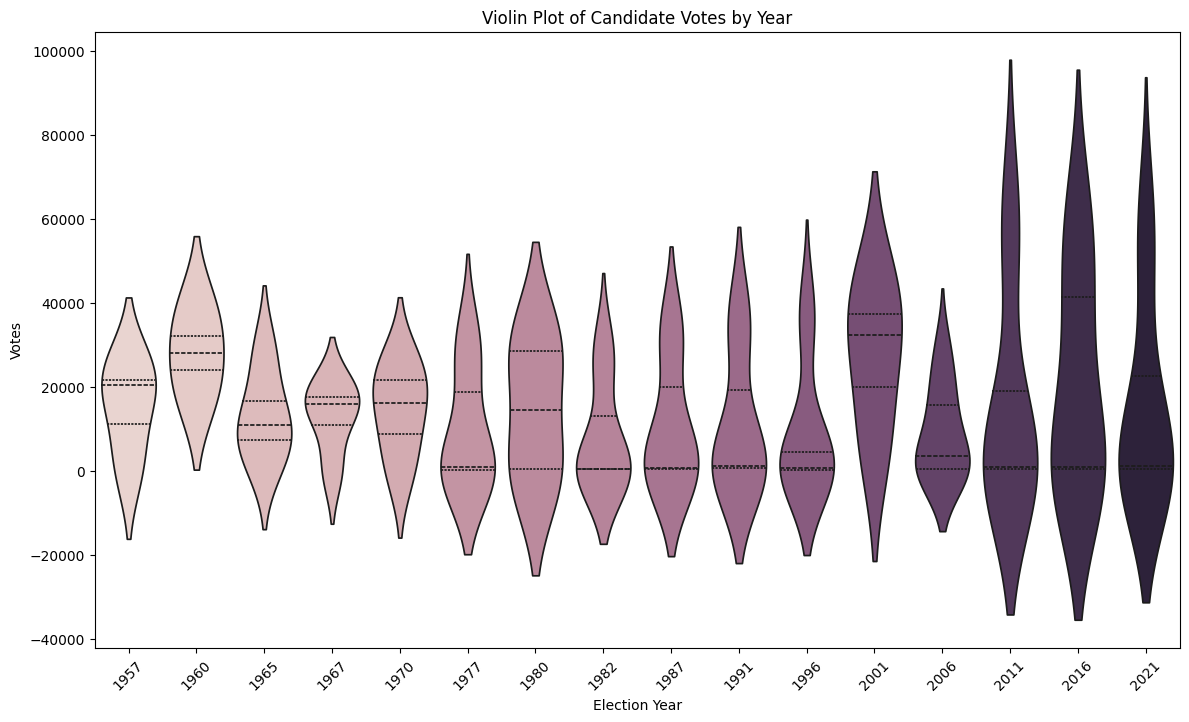

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


file_path = './KERALA_THIRUVALLA.csv'
data = pd.read_csv(file_path)

cleaned_data = data.dropna(subset=['VOTES'])

cleaned_data['VOTES'] = pd.to_numeric(cleaned_data['VOTES'], errors='coerce')

cleaned_data = cleaned_data.dropna(subset=['VOTES'])


plt.figure(figsize=(14, 8))
sns.violinplot(x='YEAR', y='VOTES', data=cleaned_data, inner="quartile", density_norm='width', hue='YEAR', legend=False)
plt.title('Violin Plot of Candidate Votes by Year')
plt.xlabel('Election Year')
plt.ylabel('Votes')
plt.xticks(rotation=45)
plt.show()

###Question 2:

For the given state, Use a scatter plot to show the correlation between the length of a candidate name (string length) and the votes gathered by the candidate.

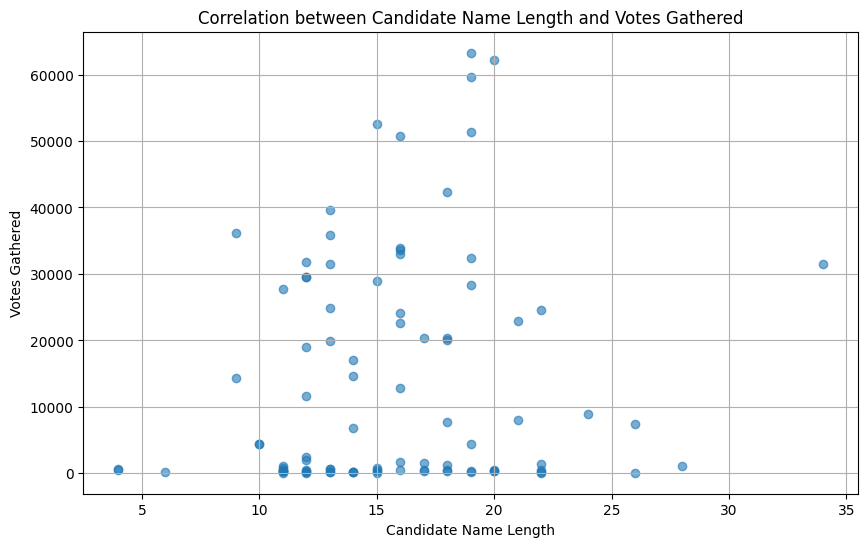

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = 'KERALA_THIRUVALLA.csv'
data = pd.read_csv(file_path)

data['Name_Length'] = data['CANDIDATE'].apply(len)

data = data.dropna(subset=['VOTES'])

data['VOTES'] = pd.to_numeric(data['VOTES'])

plt.figure(figsize=(10, 6))
plt.scatter(data['Name_Length'], data['VOTES'], alpha=0.6)
plt.title('Correlation between Candidate Name Length and Votes Gathered')
plt.xlabel('Candidate Name Length')
plt.ylabel('Votes Gathered')
plt.grid(True)
plt.show()
